In [9]:
import os
import conllu
import pandas as pd

In [10]:
path_agregated_cvs = "/home/wran/Research/memoire/experimentations_notebooks/data/6_cvs/agregated_cvs.conllu"

In [11]:
with open(path_agregated_cvs, 'r') as infile:
    parsed_conllu = conllu.parse(infile.read())

In [12]:
unormalized_deprel = {}
list_deprel = []
for sequence in parsed_conllu:
    for token in sequence:
        list_deprel.append(token["deprel"])

In [13]:
len(set(list_deprel))

71

In [14]:

deep_relations = ["fixed", "scrap", "agent", "lvc", "x", "relcl", "expl"]

def unormalize_deprel(deprel):
    for dr in deep_relations:
        if ":{}".format(dr) in deprel:
            print(deprel)
            deprel = deprel.replace(":{}".format(dr), "@{}".format(dr))
            print(deprel)
    
    if deprel == "mod@num":
        deprel = "mod:num"
    
    return deprel

In [18]:
for deprel in set(list_deprel):
    unormalize_deprel(deprel)

In [19]:
list_normalized_deprel = []
for deprel in set(list_deprel):
    normalized_deprel = deprel.replace("@", ":")
    if normalized_deprel in list_normalized_deprel:
        print(deprel, normalized_deprel)
    list_normalized_deprel.append(normalized_deprel)
len(set(list_normalized_deprel))

71

In [20]:
n_true_sequences = {}
n_true_tokens = {}

properties = ['head', 'deprel', 'pos', 'LA']
for property_ in properties:
    n_true_sequences[property_] = 0
    n_true_tokens[property_] = 0

In [21]:
n_total_sequences = 0
n_total_tokens = 0
n_true_sequences = {}
n_true_tokens = {}

properties = ['head', 'deprel', 'pos', 'LA']
for property_ in properties:
    n_true_sequences[property_] = 0
    n_true_tokens[property_] = 0
    
df_labels = []
for property_ in properties:
    df_labels += ["{}_{}".format(property_, truthiness) for truthiness in ["true", "false"]]    
df = pd.DataFrame(columns=["sequence_len"] + df_labels)
    
for i, sequence in enumerate(parsed_conllu):
    sequence_true = {}
    for property_ in properties:
        sequence_true[property_] = 0
        
    sequence_len = (len(sequence))
    
    for token in sequence:
        head_pred = int(token['misc']['head_MST'])
        head_true = int(token['head'])
        
        deprel_pred = (token['misc']['deprel_main_pred'])
        deprel_true = (token['deprel'])
        
        pos_pred = token['upos']
        pos_true = (token['misc']['upostag'])

        
        head_correct, deprel_correct = False, False
        if head_pred == head_true:
            sequence_true['head'] += 1
            head_correct = True
        
        if deprel_pred.replace("@", ":") == deprel_true.replace("@", ":"):
            sequence_true['deprel'] += 1
            deprel_correct = True
            
        if (head_correct) & (deprel_correct):
            sequence_true['LA'] += 1
            
        if pos_pred == pos_true: 
            sequence_true['pos'] += 1
    
    dict_sequence = {}
    
    for property_ in properties:
        n_true_sequences[property_] += int(sequence_true[property_] == sequence_len)
        n_true_tokens[property_] += sequence_true[property_]
        dict_sequence["{}_true".format(property_)] = sequence_true[property_]
        dict_sequence["{}_false".format(property_)] = sequence_len - sequence_true[property_]
    
    n_total_sequences += 1
    n_total_tokens += sequence_len
    dict_sequence["sequence_len"] = sequence_len
    
    df = df.append(dict_sequence, ignore_index=True)
    
for property_ in properties:
    print(property_)
    print("{:.1f}% sentences correct ({}/{})".format(100*n_true_sequences[property_]/n_total_sequences, n_true_sequences[property_], n_total_sequences))
    print("{:.1f}% tokens correct ({}/{})".format(100*n_true_tokens[property_]/n_total_tokens, n_true_tokens[property_], n_total_tokens))
    print()

head
65.5% sentences correct (5410/8259)
94.2% tokens correct (123475/131042)

deprel
54.1% sentences correct (4469/8259)
94.1% tokens correct (123250/131042)

pos
65.4% sentences correct (5400/8259)
96.8% tokens correct (126862/131042)

LA
46.8% sentences correct (3865/8259)
90.5% tokens correct (118555/131042)



In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [23]:
sns.set(color_codes=True)

In [24]:
df["sequence_len_copy"] = df['sequence_len']

In [25]:
df_groupby = df.groupby("sequence_len").sum()
for property_ in properties :
    df_groupby['ratio_{}_false'.format(property_)] = df_groupby['{}_false'.format(property_)]/df_groupby['sequence_len_copy']
df_groupby

,head_true,head_false,deprel_true,deprel_false,pos_true,pos_false,LA_true,LA_false,sequence_len_copy,ratio_head_false,ratio_deprel_false,ratio_pos_false,ratio_LA_false
sequence_len,,,,,,,,,,,,,
2,320,0,318,2,193,127,318,2,320,0.000000,0.006250,0.396875,0.006250
3,731,28,726,33,643,116,717,42,759,0.036891,0.043478,0.152833,0.055336
4,1200,48,1186,62,1164,84,1162,86,1248,0.038462,0.049679,0.067308,0.068910
5,1787,58,1759,86,1753,92,1732,113,1845,0.031436,0.046612,0.049864,0.061247
6,2684,82,2621,145,2669,97,2578,188,2766,0.029646,0.052422,0.035069,0.067968
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,90,12,99,3,96,6,87,15,102,0.117647,0.029412,0.058824,0.147059
105,95,10,102,3,100,5,93,12,105,0.095238,0.028571,0.047619,0.114286
111,94,17,102,9,102,9,93,18,111,0.153153,0.081081,0.081081,0.162162


In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
x_lim=80

In [28]:
import matplotlib as mpl
import brewer2mpl
# brewer2mpl.get_map args: set name  set type  number of colors
bmap = brewer2mpl.get_map('Set1', 'qualitative', 4)
colors = bmap.mpl_colors

params = {
   'axes.labelsize': 8,
 #  'text.fontsize': 8,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'text.usetex': False,
   'figure.figsize': [10, 5]
   }
mpl.rcParams.update(params)

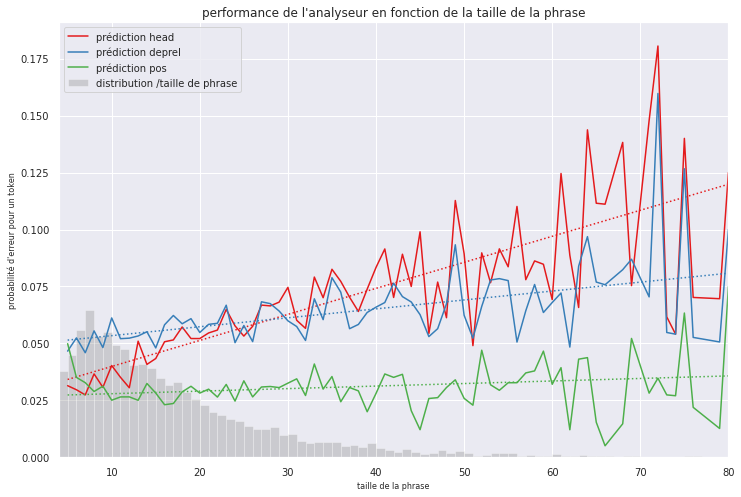

In [29]:
x_lim = [3, 80]
x = df_groupby.reset_index()['sequence_len'][x_lim[0]:x_lim[1]].to_numpy().reshape(-1, 1)

plt.figure(figsize=(12,8))
for i, property_ in enumerate(["head", "deprel", "pos"]):
    y = df_groupby['ratio_{}_false'.format(property_)][x_lim[0]:x_lim[1]].to_numpy().reshape(-1, 1)
    
    regressor = LinearRegression()  
    regressor.fit(x, y)
    
    plt.plot(x, y, color=colors[i], label="prédiction {}".format(property_))
    plt.plot(x, regressor.predict(x) ,color=colors[i], linestyle="dotted")
    
plt.hist(df["sequence_len"], bins=range(0,80), density=True, alpha= 0.3, color = "grey", label="distribution /taille de phrase")
plt.title("performance de l'analyseur en fonction de la taille de la phrase")
plt.legend()
plt.xlabel("taille de la phrase")
plt.ylabel("probabilité d'erreur pour un token")
plt.xlim([x_lim[0]+1,x_lim[1]])

for ext_file in ['png', 'svg']:
    plt.savefig("fig_error_evolution_sentence_length." + ext_file, format=ext_file)

In [30]:
len(sequence)

12

In [31]:
for sequence in parsed_conllu:
    if len(sequence) < 3:
        print(sequence)

TokenList<ah, !//>
TokenList<ah, !//>
TokenList<why, ?//>
TokenList<noting, //>
TokenList<ehen, //>
TokenList<ehen, !//>
TokenList<position, !//>
TokenList<mtschew, !//>
TokenList<mtschew, !//>
TokenList<mtschew, !//>
TokenList<mtschew, !//>
TokenList<eh, !//>
TokenList<Jesus, !//>
TokenList<ehn, ?//>
TokenList<ehn, ?//>
TokenList<ehn, !//>
TokenList<okay, !//>
TokenList<okay, !//>
TokenList<okay, !//>
TokenList<so, &//>
TokenList<ehen, //>
TokenList<yes, ?//>
TokenList<hehe, //>
TokenList<toh, //>
TokenList<okay, //>
TokenList<okay, //>
TokenList<hm, //>
TokenList<okay, //>
TokenList<haha, //>
TokenList<okay, !//>
TokenList<tomorrow, ?//>
TokenList<ehn, !//>
TokenList<ah, !//>
TokenList<toh, //>
TokenList<CAC, ?//>
TokenList<hm, //>
TokenList<eh, //>
TokenList<ehn, !//>
TokenList<confirm, !//>
TokenList<eyah, !//>
TokenList<eyah, !//>
TokenList<eyah, !//>
TokenList<uhm, ?//>
TokenList<uhum, !//>
TokenList<no, !//>
TokenList<all, &//>
TokenList<haha, //>
TokenList<fai-, &//>
TokenList<

In [37]:
list_all_deprel = []

list_failed_deprel = []
couple_all_deprel_failed = []

couple_restricted_deprel_fail = []
couple_under_specified = []
couple_over_specified = []

list_deprel_true = []
list_deprel_pred = []
list_succeed_deprel = []
list_succeed_head = []
list_token_head = []
list_token_dep = []
list_syn_dist = []
list_sequence_len = []
for i, sequence in enumerate(parsed_conllu):
    for token in sequence:
        dict_row = {}
        list_all_deprel.append(deprel_true)
        list_syn_dist.append(int(token["head"])- int(token['id']))
        list_sequence_len.append(len(sequence))
        
        deprel_pred = (token['misc']['deprel_main_pred'])
        deprel_true = (token['deprel']).replace("@",":")
        list_deprel_true.append(deprel_true)
        list_deprel_pred.append(deprel_pred)
        
        list_token_head.append(sequence[token["head"]-1]["form"])
        list_token_dep.append(token["form"])
        if deprel_pred.replace("@", ":") != deprel_true.replace("@", ":"):
            couple_relation = "{}___{}".format(deprel_true, deprel_pred)
            if deprel_true in deprel_pred:
                couple_over_specified.append(couple_relation)
            
            elif deprel_pred in deprel_true:
                couple_under_specified.append(couple_relation)
                
            else:
                couple_restricted_deprel_fail.append(couple_relation)                
                list_failed_deprel.append(deprel_true)
                succeed_deprel = 0
            couple_all_deprel_failed.append(couple_relation)
        
        else:
            succeed_deprel = 1
        
        head_pred = int(token['misc']['head_MST'])
        head_true = int(token['head'])
        
        if head_pred == head_true:
            succeed_head = 1
        else:
            succeed_head = 0
        
        list_succeed_deprel.append(succeed_deprel)
        list_succeed_head.append(succeed_head)
            
        
        

In [33]:
data = zip(
    list_deprel_true, 
    list_deprel_pred, 
    list_succeed_deprel, 
    list_succeed_head,
    list_token_head,
    list_token_dep,
    list_syn_dist,
    list_sequence_len,
)
df_deprel = pd.DataFrame(data,columns=["deprel_true", "deprel_pred", "succeed_deprel", "succeed_head",
                                      "token_head", "token_dep", "syn_dist", 'sequence_len'])


In [34]:
from collections import Counter

On peut voir dans les trois cellules suivantes que sur nos 7500 erreurs globales de mauvais etiquettage de la fonction, 10% (700) sont liées à une sous-spécification de la fonction (mod à la place de mod:emph) et 10% sont liées à une sur-spécification (mod:emph au lieu de mod). 
Ces erreurs, qui representent 20% de nos erreures de labelisation, ne sont pas de graves erreurs mais peuvent entre autre nous aider à déceler des ambiguités d'annotations 

In [44]:
print(len(couple_over_specified))
Counter(couple_over_specified).most_common(20)

638


[('mod___mod:periph', 118),
 ('mod___mod:poss', 99),
 ('mod___mod:emph', 63),
 ('subj___subj@expl', 62),
 ('comp:obj___comp:obj@x', 40),
 ('comp:pred___comp:pred@fixed', 39),
 ('mod___mod@relcl', 32),
 ('root___root@scrap', 31),
 ('comp:obj___comp:obj@lvc', 23),
 ('comp:obj___comp:obj@scrap', 19),
 ('comp:obj___comp:obj@agent', 18),
 ('comp:obj___comp:obj@fixed', 15),
 ('det___det:num', 14),
 ('comp:obl___comp:obl@x', 13),
 ('comp:aux___comp:aux@scrap', 12),
 ('comp:pred___comp:pred@agent', 10),
 ('discourse___parataxis:discourse', 9),
 ('flat___flat:foreign', 8),
 ('compound___compound:svc', 3),
 ('mod___mod@fixed', 3)]

In [43]:
print(len(couple_under_specified))
Counter(couple_under_specified).most_common(20)

699


[('mod:emph___mod', 128),
 ('subj:expl___subj', 86),
 ('mod:periph___mod', 72),
 ('comp:obj:lvc___comp:obj', 52),
 ('comp:obj:x___comp:obj', 34),
 ('comp:pred:fixed___comp:pred', 34),
 ('root:scrap___root', 33),
 ('comp:obj:scrap___comp:obj', 26),
 ('mod:poss___mod', 26),
 ('mod:relcl___mod', 23),
 ('det:num___det', 23),
 ('comp:obj:agent___comp:obj', 20),
 ('comp:pred:agent___comp:pred', 17),
 ('conj:dicto:scrap___conj:dicto', 16),
 ('comp:aux:scrap___comp:aux', 14),
 ('comp:cleft:scrap___comp:cleft', 9),
 ('comp:pred:scrap___comp:pred', 8),
 ('subj:scrap___subj', 8),
 ('comp:obl:scrap___comp:obl', 8),
 ('comp:obl:agent___comp:obl', 8)]

In [42]:
print(len(couple_restricted_deprel_fail))
Counter(couple_restricted_deprel_fail).most_common(20)

6455


[('mod___comp:obl', 260),
 ('mod___compound', 195),
 ('mod___comp:obj', 169),
 ('comp:obj___mod', 163),
 ('comp:obl___mod', 163),
 ('comp:obj:x___comp:aux', 148),
 ('compound___mod', 142),
 ('dislocated___mod:periph', 89),
 ('mod___comp:pred', 82),
 ('comp:pred___comp:obj', 78),
 ('comp:aux___comp:obj@x', 74),
 ('comp:obj___comp:pred', 70),
 ('mod:periph___dislocated', 67),
 ('comp:pred___mod', 66),
 ('dislocated___subj', 65),
 ('comp:obj___subj', 62),
 ('subj___dislocated', 62),
 ('comp:aux___comp:pred', 58),
 ('flat___comp:obj', 56),
 ('comp:obj___compound', 55)]

In [45]:
ctr_all_deprel = Counter(list_all_deprel)
ctr_failed_deprel = Counter(list_failed_deprel)

list_deprel = []
list_total_count = []
list_failed_count = []
for deprel, all_count in ctr_all_deprel.most_common():
    list_deprel.append(deprel)
    list_total_count.append(all_count)
    list_failed_count.append(ctr_failed_deprel[deprel])

In [47]:
df2 = pd.DataFrame(zip(list_deprel, list_total_count, list_failed_count), columns=["deprel", "total_count", "failed_count"])


In [55]:
df2["ratio_fail"] = df2["failed_count"]/df2["total_count"]
df2["ratio_to_all_deprels"] = df2["total_count"]/(df2["total_count"].sum())

In [57]:
df2.to_csv("deprel_fail.csv")

In [286]:
ctr_all_words = Counter(list(df_deprel["token_dep"]))

In [287]:
ctr_all_words.most_common()

[('#', 10829),
 ('//', 6867),
 ('dey', 3817),
 ('<', 3608),
 ('go', 2935),
 ('I', 2884),
 ('di', 2630),
 ('{', 2521),
 ('}', 2521),
 ('you', 2327),
 ('na', 1823),
 ('[', 1721),
 ('for', 1690),
 ('no', 1609),
 ('|c', 1565),
 ('sey', 1558),
 ('||', 1522),
 ('e', 1509),
 ('wey', 1413),
 ('we', 1298),
 ('am', 1279),
 (']', 1216),
 ('de', 1158),
 ('so', 1078),
 ('con', 1045),
 ('be', 949),
 ('and', 919),
 ('>+', 902),
 ('dat', 888),
 ('to', 864),
 ('me', 860),
 ('dis', 851),
 ('dem', 816),
 ('//=', 816),
 ('one', 813),
 ('my', 782),
 ('do', 771),
 ('don', 762),
 ('make', 719),
 ('of', 715),
 ('im', 711),
 ('now', 706),
 ('come', 683),
 ('if', 678),
 ('say', 671),
 ('get', 662),
 ('o', 572),
 ('like', 553),
 ('your', 521),
 ('|r', 509),
 ('?//', 508),
 ('as', 490),
 ('!//', 476),
 ('people', 467),
 ('know', 451),
 ('but', 433),
 ('just', 427),
 ('see', 422),
 ('&//', 406),
 ('eh', 403),
 ('wetin', 395),
 ('fit', 369),
 ('because', 365),
 ('tell', 361),
 ('wan', 352),
 ('all', 341),
 ('talk',

In [294]:
for token, count_fail in Counter(list(df_deprel[df_deprel["succeed_deprel"] == 0]["token_dep"])).most_common():
    print(token, count_fail, "{:.0f}%".format(100*count_fail/ctr_all_words[token]))

for 278 16%
dey 251 7%
to 215 25%
like 119 22%
go 117 4%
sey 117 8%
now 104 15%
na 71 4%
make 69 10%
be 67 7%
one 63 8%
as 63 13%
of 56 8%
in 56 25%
wey 55 4%
inside 49 17%
say 47 7%
on 47 21%
so 45 4%
two 43 26%
me 42 5%
dat 40 5%
come 39 6%
con 37 4%
know 37 8%
people 36 8%
don 36 5%
five 36 27%
get 33 5%
you 33 1%
all 30 9%
because 29 8%
from 29 12%
e 29 2%
wetin 28 7%
no 28 2%
time 27 13%
dem 27 3%
dere 27 13%
day 27 22%
do 25 3%
if 25 4%
im 23 3%
nine 22 55%
see 22 5%
we 22 2%
wan 21 6%
by 21 26%
I 21 1%
am 20 2%
dis 20 2%
naira 20 22%
how 19 9%
God 19 7%
three 18 19%
meh 17 9%
twenty 17 27%
take 16 5%
when 16 5%
man 16 8%
a 16 10%
den 16 9%
outside 16 36%
who 16 28%
give 16 7%
with 16 14%
di 16 1%
why 15 15%
is 15 11%
ninety 15 62%
money 15 5%
Nigeria 15 13%
wit 14 16%
person 14 7%
own 14 10%
year 14 17%
o 14 2%
top 14 17%
small 13 6%
morning 13 21%
six 13 25%
place 13 10%
Alaska 13 37%
ting 12 5%
bitter 12 75%
thousand 12 16%
woman 11 11%
reach 11 9%
number 11 23%
my 11 1%
way 1

injury 1 25%
Vice 1 100%
cr- 1 100%
member 1 25%
Manager 1 100%
section 1 11%
relation 1 100%
embarrassing 1 100%
terms 1 100%
do- 1 50%
biko 1 100%
package 1 10%
We 1 100%
Don 1 100%
Hear 1 100%
Front 1 100%
allright 1 100%
www 1 100%
Government 1 7%
fake 1 20%
Ekiti 1 100%
Assemble 1 50%
Governor 1 50%
times 1 7%
Controller 1 100%
NIS 1 100%
Inland 1 100%
FR 1 100%
e-services 1 100%
NJC 1 100%
Mrs 1 25%
Had- 1 100%
LASIEC 1 100%
All 1 100%
Progressive 1 100%
chairmo 1 50%
bank 1 20%
terror 1 100%
Bank 1 33%
CBN 1 100%
ahead 1 25%
walahi 1 100%
quit 1 100%
spark 1 100%
kd 1 100%
shorten 1 100%
shun 1 100%
silva 1 100%
fried 1 100%
blend 1 20%
dash 1 100%
bringing 1 100%
feel 1 4%
somebody 1 8%
en- 1 100%
mon- 1 100%
sliding 1 100%
case 1 14%
swing 1 50%
door 1 8%
remaining 1 25%
hence 1 100%
tree 1 14%
control 1 17%
teach 1 2%
kukuma 1 20%
yesterday 1 5%
ba 1 14%
ke 1 50%
nan 1 100%
tuwo 1 100%
gaskiya 1 50%
sosei 1 100%
Bariga 1 17%
Emmanuel 1 33%
High 1 50%
n- 1 33%
m- 1 25%
resume 

In [ ]:
ctr_all_words[token]

In [282]:
df_deprel[df_deprel["succeed_deprel"] == 0].groupby("token_dep").sum()

,succeed_deprel,succeed_head
token_dep,,
!//=,0,1
##,0,0
&//,0,0
's,0,0
*,0,0
...,...,...
your,0,2
yoursef,0,1
youths,0,0


In [40]:
df_deprel

,deprel_true,deprel_pred,succeed_deprel,succeed_head,token_head,token_dep,syn_dist,sequence_len
0,subj,subj,1,0,dey,life,6,11
1,mod,root,0,0,life,for,-1,11
2,comp:obj,comp:obj,1,1,for,me,-1,11
3,mod,mod,1,0,life,as,-3,11
4,mod,mod,1,1,pikin,small,1,11
...,...,...,...,...,...,...,...,...
131037,mod,compound,0,1,version,English,1,12
131038,comp:obj,comp:obj,1,1,hear,version,-3,12
131039,mod,mod,1,1,version,of,-1,12
131040,comp:obj,comp:obj,1,1,of,me,-1,12
